# THE BRIEF

The purpose of this project is to use the Seattle Kings County Housing sales data (kc_housing_data.csv) to establish what relationships there are between a property's attributes and its sale price in the area. 

The first stage was to establish the scope of the project. To do this, we outlined three key questions that we wanted to answer through our analysis:

1. What attributes of a property most accurately determine its value?
2. What is the relationship between a property's distance from downtown Seattle and its price?
3. Can price predictions be improved by conducting a more local analysis of the data?

# 1. IMPORTING LIBRARIES AND THE DATASET 

Importing the relevant python libraries to be used for the preprocessing and analysis.

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import math
import missingno

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

Importing the raw data from a .csv file and using pandas to transform it into a dataframe. We display a preview of the dataset (top 5 rows) to understand which variables are present. We can begin to determine what the target variable is and what the independent variables are.

In [2]:
df = pd.read_csv("kc_house_data.csv")

# 2. DATA EXPLORATION / PREPROCESSING

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


The dataset contains house price sales data for the city of Seattle for a period over 2014 & 2015. It contains individual house price sales $ amounts with a list of descriptive characteristics for each house, including number of bedrooms, bathrooms, square footage of living space, basement space, etc. Price is our target variable. 

## 2.1. Null Values

First we want to determine which values are missing from the dataset. We can then decide whether there is an appropriate way to fill in these missing values or to ignore them in our analysis. missingo gives a clear visual representation of where missing values exist in the dataset.

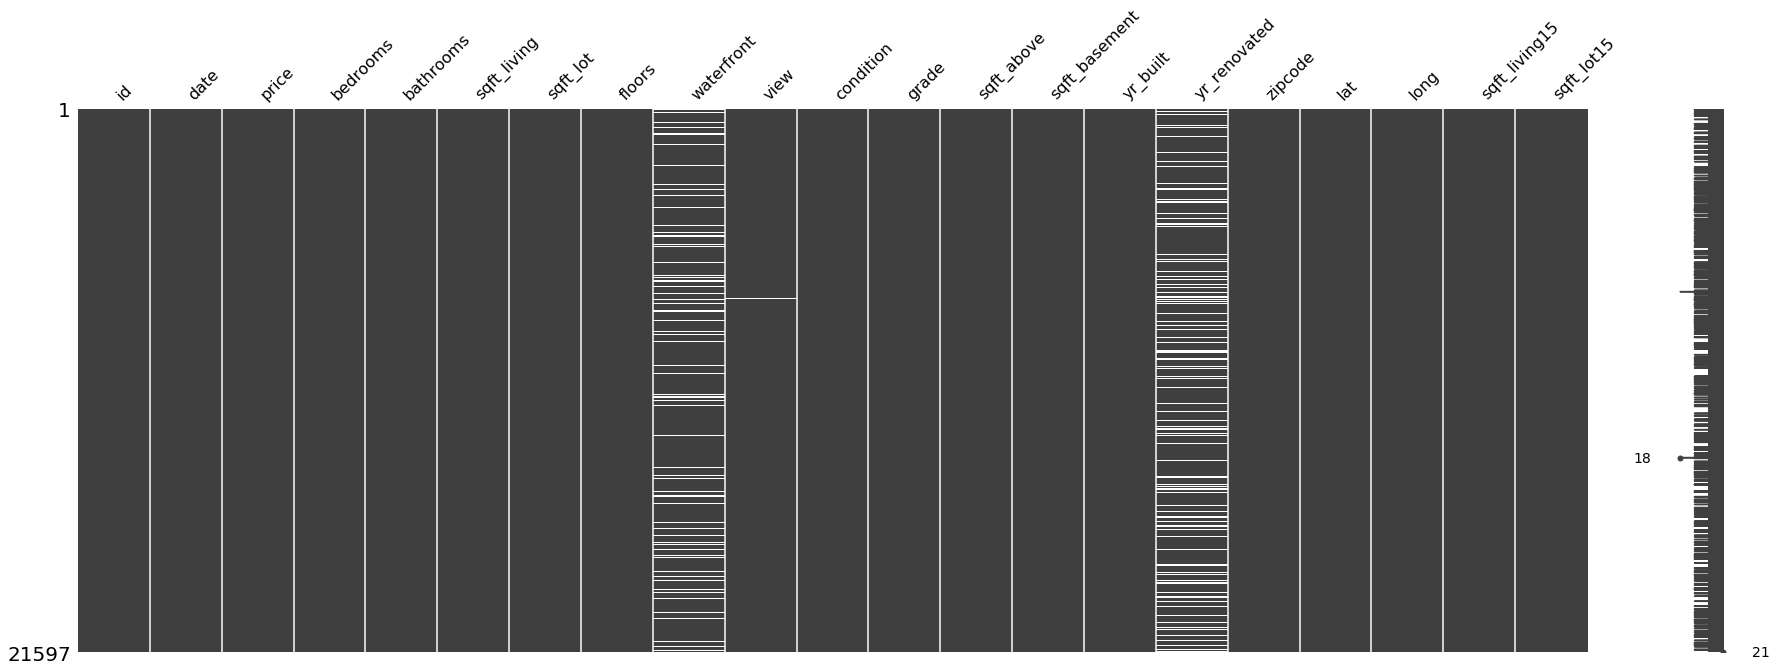

In [4]:
missingno.matrix(df, figsize=(30,10))

We can determine exactly how many missing values are present by using the pandas isnull method.

In [5]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### 2.1.1 Waterfront

To determine what to do about the null values contained in the waterfront column, it would be useful to plot the properties on a map. From this it may be clear whether they can or cannot be classed as waterfront properties. Using the folium package, the longitude and latitude of the properties allow us to plot them on a map of Seattle. We must install the folium package as it is not part of the Learn environment.

In [6]:
# !conda install -c conda-forge folium=0.8.3 --yes

In [7]:
import folium
print('Folium installed and imported!')

Folium installed and imported!


With folium installed we can now define the world map centered around Seattle with an apprpriate zoom level.

In [8]:
latitude = 47.5
longitude = -122.3

seattle_map = folium.Map(location=[latitude, longitude], zoom_start=8)
seattle_map

Another dataframe is created which contains only the properties that have null values for the waterfront variable. The coordinates in this dataframe are then used to plotthe properties on a map.

In [9]:
null_waterfront = df[pd.isnull(df['waterfront'])]

In [10]:
seattle_map = folium.Map(location=[latitude, longitude], zoom_start=8)
houses = folium.map.FeatureGroup()

for lat, lng, in zip(null_waterfront.lat, null_waterfront.long):
    houses.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=3,
            color='green',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

seattle_map.add_child(houses)

Its clear that most of these properties are not directly on the waterfront. However, there is no explicit definition of what criteria need to be met in order for a property to be considered as being on the waterfront. To get a better picture of this criteria, a new dataframe containing only the properties that are on the waterfront is made. This is then plotted on a new map.

In [11]:
true_waterfront = df[df['waterfront'] == 1]

In [12]:
seattle_map = folium.Map(location=[latitude, longitude], zoom_start=8)
houses = folium.map.FeatureGroup()

for lat, lng, in zip(true_waterfront.lat, true_waterfront.long):
    houses.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

seattle_map.add_child(houses)

Its clear when comparing the null and true waterfront locations that the vast majority of null waterfront properties would not qualify as being on the waterfront. In most cases, the reason for their values being null is probably due to the question being left empty when assessing the property, as the assessor thought leaving it blank would intuitively be seen as not being a waterfront property.

For this analysis all null waterfront values are made 0, meaning they do not qualify as waterfront properties.

In [13]:
print(df['waterfront'].unique())

[nan  0.  1.]


In [14]:
df['waterfront'] = df['waterfront'].fillna(0)
print(df['waterfront'].unique())

[0. 1.]


As can be seen above, the only unique values that exist in the waterfront column are now 0 and 1.

### 2.1.2 View

Only 63 out of 21597 housing viewing datapoints have been left null. In most cases this is assumed to be due to the house having had 0 views and therefore the datapoint has been left blank, assuming that this would be interpreted as the house having had no views yet.

Therefore, the null values in this column are all made to equal 0.

In [15]:
print(df['view'].unique())

[ 0. nan  3.  4.  2.  1.]


In [16]:
df['view'] = df['view'].fillna(0)
print(df['view'].unique())

[0. 3. 4. 2. 1.]


As can be seen above, the only unique values that exist in the view column are now 0 and 1.

### 2.1.3  Year Renovated

In [17]:
df['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

As can be seen above, there are null values and 0 values in this column. Both of these need to be addressed. It is assumed that where there are 0 values, the assessor has misinterpreted the question and is actually indicating that the house has never been renovated. It is also assumed that where null values exist, the question was not answered because the assessor thought a blank would be interpreted as never having been renovated.

In [18]:
zero_renovated = df.loc[df['yr_renovated'] == 0]
len(zero_renovated)

17011

In [19]:
df['yr_renovated'].isnull().sum()

3842

There are 17,011 zero values and 3842 null values in the year renovated column.

In [20]:
df['yr_renovated'] = np.where(df['yr_renovated']==0, df['yr_built'], df['yr_renovated'])

In [21]:
df['yr_renovated'].fillna(df['yr_built'], inplace=True)

In [22]:
df['yr_renovated'].unique()

array([1955., 1991., 1933., 1965., 1987., 2001., 1995., 1963., 1960.,
       2003., 1942., 1927., 1977., 1900., 1979., 1994., 1916., 1921.,
       1969., 1947., 1968., 1985., 1941., 1915., 1909., 1948., 2005.,
       1929., 1981., 2002., 1904., 1996., 2000., 1984., 2014., 1922.,
       1959., 1966., 1953., 1950., 2008., 1954., 1973., 1925., 1989.,
       1972., 1986., 1956., 1992., 1964., 1952., 1961., 2006., 1988.,
       1962., 1939., 1967., 1975., 1980., 1910., 1983., 2010., 1978.,
       1905., 1971., 1945., 1924., 1990., 1926., 2004., 1923., 2007.,
       2013., 1976., 1949., 1999., 1901., 1993., 1920., 1997., 1943.,
       1940., 1918., 1928., 1974., 1911., 1930., 1936., 1937., 1982.,
       1908., 1931., 1957., 1998., 1913., 1907., 1958., 2011., 2012.,
       1912., 1917., 1946., 1951., 1932., 1944., 1902., 2009., 1970.,
       2015., 1934., 1938., 1919., 1914., 1906., 1903., 1935.])

The 0 and null values were replaced with the year the property was built so as to prevent any zero skew in the data.

## 2.2. Non-numeric Data

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### 2.2.1 Square Foot Basement

The sqft_basement column contains objects. As this variable is a numberic value its contents need to be either floats or integers so that we can operate on them later.

In [24]:
# df['sqft_basement'].astype(float)

A direct conversion of the column objects to floats does not work, as can be seen from the error above (uncomment and run the cell). The error reads as follows:

        ValueError: could not convert string to float: '?'
        
This tells us that the column contains '?'s and this is the reason why the column values could not be made into floats.

In [25]:
df['sqft_basement'].isin(['?']).sum(axis=0)

454

A total of 454 '?'s exist in the column. It is thought that similarly to other varibles, the question has been left blank when assessing the property, as the assessor has assumed this will be interpreted as the property having no basement. Therefore all '?' values are to be changed to 0.

In [26]:
df['sqft_basement'] = df['sqft_basement'].replace("?",'0.0')

In [27]:
df['sqft_basement'].isin(['?']).sum(axis=0)

0

A check for '?'s shows that they have all been replaced with 0 values.

Next, the entire column must be changed from strings to floats.

In [28]:
df['sqft_basement'] = df['sqft_basement'].astype(float)

## 2.3. Final Preprocessing Check

This section contains the final checks to make sure that all issues with the data have been dealt with. The first check is for any remaining null values.

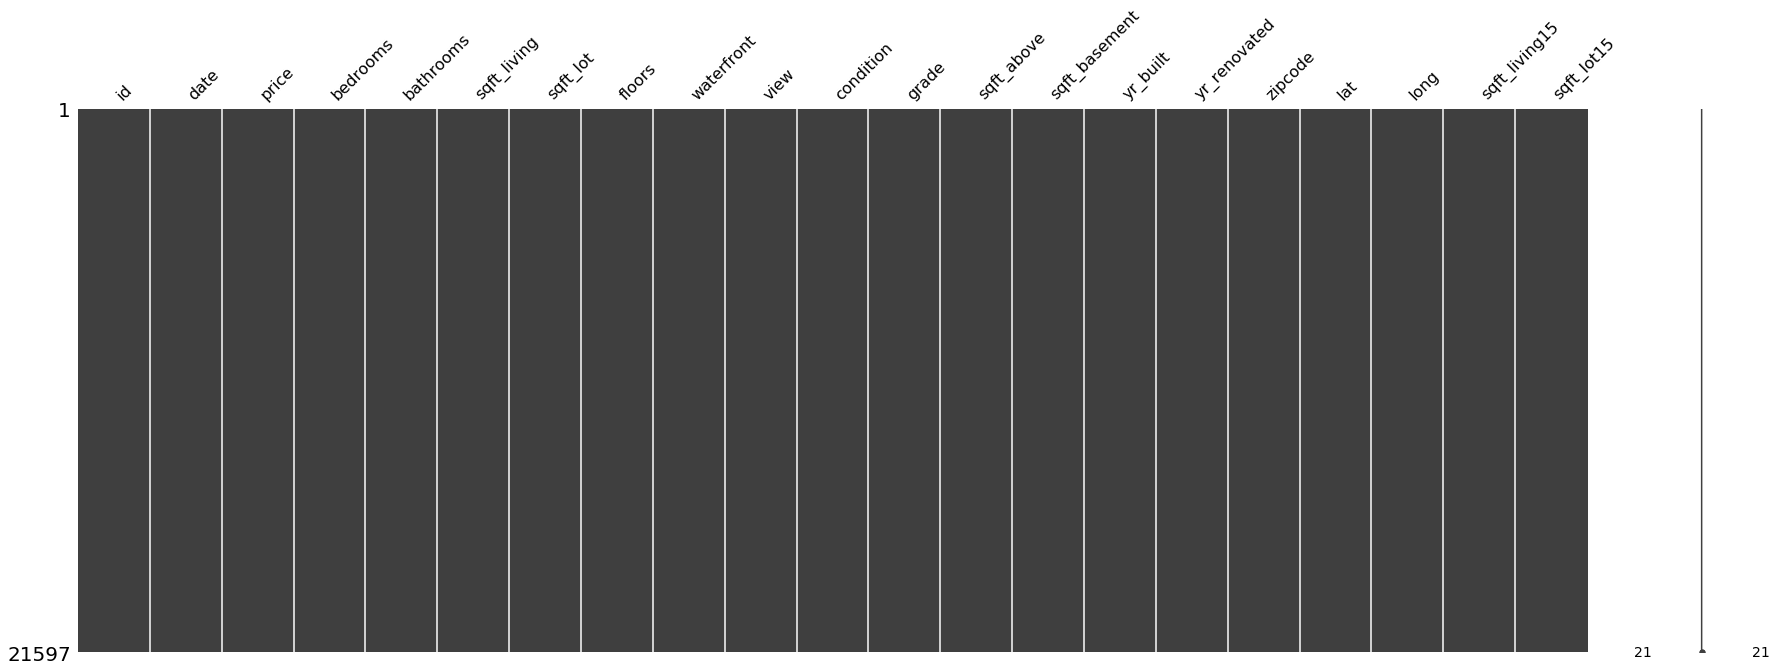

In [29]:
missingno.matrix(df, figsize=(30,10))

In [30]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

It is clear that no null values remain in the dataset.

The next check is for any numeric variables that exist as objects in the dataset.

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


All of the numeric variables are now stored as floats or integers. The data cleaning section of the project is complete.

## 2.4. Calculating the Distance to Downtown Seattle

One of the questions we wanted to answer was 'how does a property's price change with its distance from the city?'. To do this, the property's latitude and longitude were used to calculate its distance to Downtown Seattle. Downtown Seattle was chosen as this is the city's hub for restaurants and entertainment.

city_lat = 47.6050
city_long = -122.3344

Downtown Seattle's coordinates are 47.6050 Degress North, -122.3344 Degrees West.

In [37]:
def distance_function(city_lat, city_long, house_lat, house_long):
    
    R = 6372800  # Earth radius in meters
    phi1, phi2 = math.radians(city_lat), math.radians(house_lat)
    dphi       = math.radians(house_lat - city_lat)
    dlambda    = math.radians(house_long - city_long)
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))/(1000*1.60934) # Conversion from meters to miles.

The above cell contains a function that calculates the distance between two sets of coordinates, accounting for the curvature of the Earth.

In [38]:
distance_list = []

for i in range(len(df)):
    
    house_lat = df.loc[i, 'lat'] 
    house_long = df.loc[i, 'long']
    
    distance = distance_function(city_lat, city_long, house_lat, house_long)
    
    distance_list.append(distance)

We then iterate through the pandas dataframe using the latitude and longitude of each house in thee distance_function. The distance values are then appended to a list.

In [39]:
len(df) == len(distance_list)

True

The above cell checks that the length of the new diatnace list is equal to the length of the dataframe. This return True, showing that the iteration through the dataframe worked for each house.

A new column is then created in the dataframe named 'distance_to_town'. This is set to be equal to the distance list.

In [40]:
df['distance_to_town'] = distance_list

The below cell is a preview of the dataframe. As can be seen, the distance_to_town column has been added successfully.

In [41]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance_to_town
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,7.420145
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,8.049092
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,10.326482
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,1965.0,98136,47.5208,-122.393,1360,5000,6.429078
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,13.508751


## 2.5. Accounting for Inflation